In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.interpolate import interp1d
import seaborn as sns
from astropy.cosmology import WMAP9 as cosmo
import pandas as pd
import matplotlib.ticker as ticker
from scipy import constants as sc

#Packages related to spectra
import window_function_2
import pspec_copy
import make_universe_copy
import cross_pspec

#packages for HERA and 21cm FG simulation
import HERA_hack_FG
import FG_pygsm

#packages for CCAT and [CII] FG simulation
import CII_foregrounds
from CCAT_p import CCAT_p

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=11
plt.rcParams['xtick.labelsize']=11



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [380]:
field_21cm = np.loadtxt("21cm_data.txt").reshape(50,50)
field_21cm /= 100

CII_field = np.loadtxt("CII_data.txt").reshape(50,50)

# CII_CCAT = np.loadtxt("CII_CCAT.txt").reshape(50,50) # CII
# CII_FG = np.loadtxt("CII_CCAT_FG.txt").reshape(50,50)
 
# HERA_field = np.loadtxt("HERA.txt").reshape(50,50) 
# HERA_FG = np.loadtxt("HERA_FG.txt").reshape(50,50)

FG_21cm = np.loadtxt("FG_21cm.txt").reshape(50,50).T #HERA FG only 
FG_CII =  np.loadtxt("FG_CII.txt").reshape(50,50) #CCAT FG only 
 
Lx = 325.5
Ly = 325.5
nbins = 30

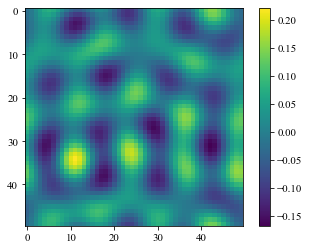

In [381]:
plt.imshow(field_21cm)
plt.colorbar()

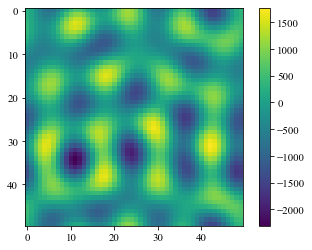

In [382]:
plt.imshow(CII_field)
plt.colorbar()

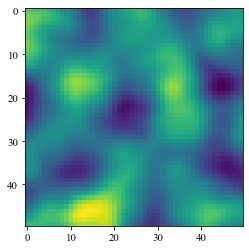

In [321]:
plt.imshow(HERA_field) #what is HERA field??

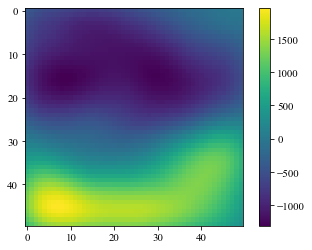

In [325]:
plt.imshow(HERA_FG)
plt.colorbar()

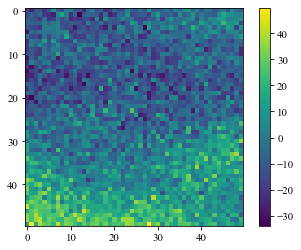

In [30]:
field_21cm = np.loadtxt("21cm_data.txt").reshape(50,50)

################## TELESCOPE STUFF ##################
dishes = np.array([[0,0],[0,-57.39295490174667],[30,0],[0,60],[2,55]])#,[47,2],[45,23],[56,21],[30,115],[48,52],[100,100],[0,200],[115,30],[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])
data = np.loadtxt('/Users/hannahfronenberg/desktop/MSC1/HERA Noise/hera_positions_staged/antenna_positions_350.dat')
hera_bls = data[::2,:-1]

npix_row,npix_col = 50,50

Lx = 325.5
Ly = 325.5

pbeam = True 
norm = True 

# acorner = np.array([[120,280],[122,282],[120,282],[122,280]])


acorner = np.array([[119,274],[121,276],[119,276],[121,274]])

HERA = HERA_hack_FG.telescope(hera_bls, latitude=-30, channel_width=97800, Tsys=300, beam_width=10, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 3, freq = 140, delta_t = 0.1 ,corners = acorner, beam_sigma_cutoff=1, sky_shape = (npix_row,npix_col), norm = norm , pbeam = pbeam)


RA = np.linspace(0,0.0349066,50) #rads (2 deg by 2 deg) 
DEC = np.linspace(0,0.0349066,50) #rads (2 deg by 2 deg) 

delta_RA = (RA[1]-RA[0])
delta_DEC = (DEC[1]-DEC[0])
omega_pix = np.abs((RA[1]-RA[0])*(DEC[1]-DEC[0])) #in sr


# x-corr NO FG

In [375]:
nreals = 100
nbins = 30

xspec_HERA_CCAT = []
kmodes = []

stacked_sky = np.hstack((field_21cm).T) 
sky = np.real(obs.convolve_map(stacked_sky,None,None))
square_sky_noFG = np.reshape(sky,(npix_row,npix_col)).T

for i in range(nreals):
    
    obs.generate_map_noise(None, None)
    noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)))
    full_map = square_sky_noFG + noise/300
    
    noisy_convolve = CCAT_p(CII_field,RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75)

    
    x_spec = cross_pspec.Cross_Spectrum(full_map,noisy_convolve,Lx,Ly,nbins,0.15)
    p_cross = x_spec.compute_2D_pspec()
    xspec_HERA_CCAT.append(p_cross[1])


    
    if i == 0:
        kmodes.append(p_cross[0])
    else:
        pass



In [376]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

xspec_HERA_CCAT = np.asarray(xspec_HERA_CCAT)

ave_xspec_HERA_CCAT = np.sum(xspec_HERA_CCAT,axis = 0)/nreals

sigma_HERA_CCAT = []

for i in range(nbins-1):
    k_dist = xspec_HERA_CCAT[:,i]
    sigma_HERA_CCAT.append(np.std(k_dist))

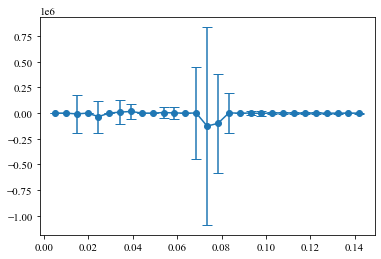

In [377]:
plt.errorbar(np.asarray(kmodes)[0],ave_xspec_HERA_CCAT,xerr = None, yerr = sigma_HERA_CCAT, capsize = 5)
plt.scatter(p_cross_FG[0],ave_xspec_HERA_CCAT)


In [290]:
data_hera_ccat = [ave_xspec_HERA_CCAT,sigma_HERA_CCAT]

HERA_CCAT = open("data_hera_ccat.txt", "w")

for row in data_hera_ccat:
    np.savetxt(HERA_CCAT, row)

HERA_CCAT.close()

# x-corr FG 1obs

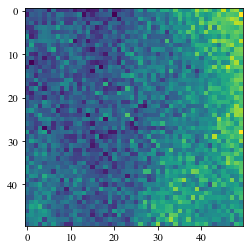

In [318]:
plt.imshow(FG_21cm)

In [386]:
nreals = 100
nbins = 30

xspec_FG_null = []
kmodes = []

# stacked_sky = np.hstack((field_21cm).T) #make map 1D
stacked_fg = np.hstack((FG_21cm).T)
sky = np.real(obs.convolve_map(stacked_fg,None,None))
square_sky = np.reshape(sky,(npix_row,npix_col)).T

for i in range(nreals):
    
    obs.generate_map_noise(None, None)
    noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)))
    full_map = square_sky + noise/300
    
    noisy_convolve = CCAT_p((FG_CII),RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75) 
    
    x_spec = cross_pspec.Cross_Spectrum(noisy_convolve,full_map,Lx,Ly,nbins,0.15)
    p_cross = x_spec.compute_2D_pspec()
    xspec_FG_null.append(p_cross[1])


    
    if i == 0:
        kmodes.append(p_cross[0])
        
    else:
        pass


In [387]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

xspec_FG_null = np.asarray(xspec_FG_null)

ave_xspec_FG_null = np.sum(xspec_FG_null,axis = 0)/nreals

sigma_FG_null = []

for i in range(nbins-1):
    k_dist = xspec_FG_null[:,i]
    sigma_FG_null.append(np.std(k_dist))

<ErrorbarContainer object of 3 artists>

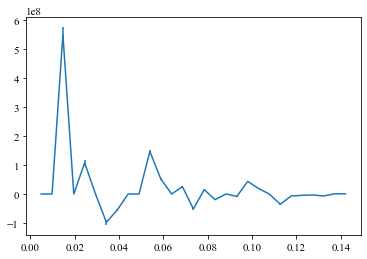

In [388]:
plt.errorbar(np.asarray(kmodes)[0],ave_xspec_FG_null,xerr = None, yerr = sigma_FG_null)#sigma_HERA_CCAT*np.ones(29)*0.2, capsize = 5)
# plt.axvline(x = 0.074)

In [389]:
data_fg_null  = [ave_xspec_FG_null ,sigma_FG_null]

FG_1obs = open("data_hera_ccat_fg_null .txt", "w")

for row in data_fg_null:
    np.savetxt(FG_1obs, row)

FG_1obs.close()

# X-corr N obs FG

In [233]:
def ps(x):
    mu, sigma = 0.08,0.005
    return  np.exp( - (x - mu)**2 / (2 * sigma**2))

make_uni = make_universe_copy.universe(ps,npix_row,npix_col,Ly,Lx, mean = None) #100 Mpc by 100Mpc

In [369]:
nreals = 100

xspec_FG_Nobs = []

for i in range(nreals):
    field_21cm = make_uni.make_2D_universe()
    CII_field = field_21cm*(-8000)
    
    stacked_fg = np.hstack((FG_21cm).T)
    stacked_sky = np.hstack((field_21cm).T)
    sky = np.real(obs.convolve_map(stacked_sky+stacked_fg,None,None))
    square_sky = np.reshape(sky,(npix_row,npix_col)).T
    
    obs.generate_map_noise(None, None)
    noise = np.real(np.reshape(obs.noise,(npix_row,npix_col)))
    
    full_map_FG = square_sky + noise/300
    
    CII_full = CII_field +CII_FG
    
    noisy_convolve_FG = CCAT_p(CII_full,RA,DEC,200.36,6,True, 0.86e6, 3*(60*60), 0.75)
    
    x_spec = cross_pspec.Cross_Spectrum(noisy_convolve_FG,full_map_FG,Lx,Ly,nbins,0.15)
    p_cross = x_spec.compute_2D_pspec()
    xspec_FG_Nobs.append(p_cross[1])
    
   

In [370]:
#COMPUTE AVERAGE AND NOISE ERROR BARS

xspec_FG_Nobs = np.asarray(xspec_FG_Nobs)

ave_xspec_FG_Nobs = np.sum(xspec_FG_Nobs,axis = 0)/nreals

sigma_FG_Nobs = []

for i in range(nbins-1):
    k_dist = xspec_FG_Nobs[:,i]
    sigma_FG_Nobs.append(np.std(k_dist))

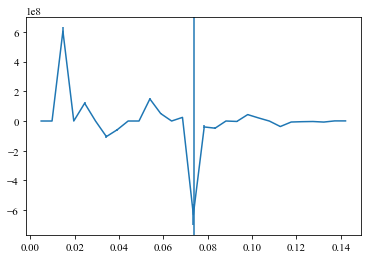

In [372]:
plt.errorbar(np.asarray(kmodes)[0],ave_xspec_FG_Nobs,xerr = None, yerr = sigma_FG_Nobs)
plt.axvline(x = 0.074)

In [373]:
data_hera_ccat_fg_Nobs = [ave_xspec_FG_Nobs,sigma_FG_Nobs]

HERA_CCAT_Nobs = open("data_hera_ccat_fg_Nobs.txt", "w")

for row in data_hera_ccat_fg_Nobs:
    np.savetxt(HERA_CCAT_Nobs, row)

HERA_CCAT_Nobs.close()